In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf


In [2]:
df = pd.read_csv("../Data/Combined_Delayed_2Days.csv")
df = df[["Label_delayed_2Days","Tweets_clean_more"]]
df.head()

,Label_delayed_2Days,Tweets_clean_more
0,Decrease,to super clear i dont wish could i mandat anyt...
1,Increase,ye get regulatori pushback may avail region go...
2,Decrease,dome barrel weld made bar pretti good bar need...
3,Decrease,the exec conf room tesla use call denali i dec...
4,Increase,sad hear david bowi die he amaz


In [3]:
train,test = train_test_split(df,train_size=0.8,random_state=123)
train.head()

,Label_delayed_2Days,Tweets_clean_more
1282,Decrease,rd dad empti articl one day starship land rust...
1235,Increase,exactli also definit come haha will rel recent...
597,Decrease,regard gov christi action imped direct sale au...
956,Increase,max acceler x graviti altitud later distanc ve...
550,Decrease,all system remain green launch pm est tomorrow...


In [6]:
label = preprocessing.LabelEncoder()
train["label"] = label.fit_transform(train["Label_delayed_2Days"])
test['label'] = label.transform(test['Label_delayed_2Days'])
train.head()

,Label_delayed_2Days,Tweets_clean_more,label
1282,Decrease,rd dad empti articl one day starship land rust...,0
1235,Increase,exactli also definit come haha will rel recent...,1
597,Decrease,regard gov christi action imped direct sale au...,0
956,Increase,max acceler x graviti altitud later distanc ve...,1
550,Decrease,all system remain green launch pm est tomorrow...,0


In [7]:
x_train = train['Tweets_clean_more']
x_test = test['Tweets_clean_more']

y_train = train['label']
y_test = test['label']

In [8]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [9]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

2022-12-08 00:45:01.050713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [11]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout1")(outputs['pooled_output'])
l = tf.keras.layers.Dense(100,  activation='relu', name='output1')(l)
l = tf.keras.layers.Dropout(0.2, name="dropout2")(l)
l = tf.keras.layers.Dense(50, activation='relu', name='output2')(l)
l = tf.keras.layers.Dropout(0.2, name="dropout3")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [13]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
36/36 [==============================] - 195s 5s/step - loss: 0.7120 - accuracy: 0.4595
Epoch 2/10
36/36 [==============================] - 178s 5s/step - loss: 0.7025 - accuracy: 0.4991
Epoch 3/10
36/36 [==============================] - 179s 5s/step - loss: 0.7031 - accuracy: 0.4701
Epoch 4/10
36/36 [==============================] - 181s 5s/step - loss: 0.6994 - accuracy: 0.4798
Epoch 5/10
36/36 [==============================] - 176s 5s/step - loss: 0.6991 - accuracy: 0.4877
Epoch 6/10
36/36 [==============================] - 172s 5s/step - loss: 0.6946 - accuracy: 0.4947
Epoch 7/10
36/36 [==============================] - 171s 5s/step - loss: 0.6930 - accuracy: 0.4771
Epoch 8/10
36/36 [==============================] - 172s 5s/step - loss: 0.6914 - accuracy: 0.4833
Epoch 9/10
36/36 [==============================] - 2097s 60s/step - loss: 0.6967 - accuracy: 0.4648
Epoch 10/10
36/36 [==============================] - 185s 5s/step - loss: 0.6897 - accuracy: 0.4894


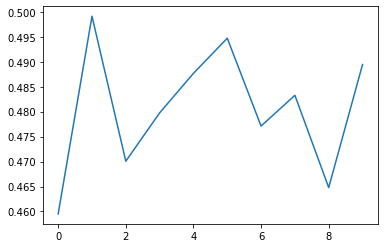

In [15]:
acc = history.history['accuracy']

loss = history.history['loss']

plt.plot(acc)

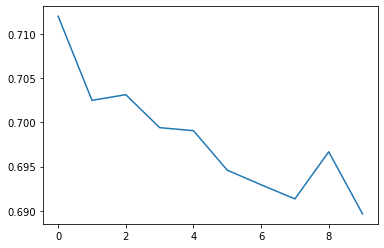

In [16]:
plt.plot(loss)

In [17]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

y_pred = np.where(y_pred > 0.5, 1, 0)

9/9 [==============================] - 60s 7s/step


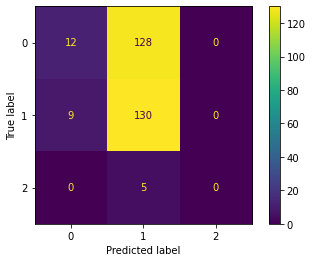

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,classification_report

cm = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [22]:
print("Accuracy:",acc)
print("classification report:\n",classification_report(y_test,y_pred))

Accuracy: 0.5
classification report:
               precision    recall  f1-score   support

           0       0.57      0.09      0.15       140
           1       0.49      0.94      0.65       139
           2       0.00      0.00      0.00         5

    accuracy                           0.50       284
   macro avg       0.36      0.34      0.27       284
weighted avg       0.52      0.50      0.39       284



/Users/taoyu/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taoyu/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taoyu/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier